## Motion Correction demo

This notebook demonstrates the various routines for motion correction in the CaImAn package. It demonstrates the usage of rigid and piecewise rigid motion correction on a two-photon calcium imaging dataset using the NoRMCorre algorithm [[1]](#normcorre), as well as several measures for quality assessment. This notebook should be interpreted more as a tutorial of the various methods. In practice, you can use either rigid or piecewise rigid motion correction depending on the motion of the dataset.

The dataset used in this notebook is provided by Sue Ann Koay and David Tank, Princeton University. This is a two photon calcium imaging dataset. For motion correction of one photon microendoscopic data the procedure is similar, with the difference, that the shifts are inferred on high pass spatially filtered version of the data. For more information check the demos for one photon data in the CaImAn package.

More information about the NoRMCorre algorithm can be found in the following paper:

<a name="normcorre"></a>[1] Pnevmatikakis, E.A., and Giovannucci A. (2017). NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data. Journal of Neuroscience Methods, 291:83-92 [[paper]](https://doi.org/10.1016/j.jneumeth.2017.07.031)

In [1]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os.path
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.source_extraction.cnmf import params as params
import caiman.base.movies.movie as movie
from caiman.utils.utils import download_demo

C:\Users\linda\AppData\Local\Temp\ipykernel_2756\3539405233.py:20: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
C:\Users\linda\AppData\Local\Temp\ipykernel_2756\3539405233.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
        4080 [__init__.py:            <module>():47] [2756] Creating converter from 7 to 5
        4082 [__init__.py:            <module>():47] [2756] Creating converter from 5 to 7
        4082 [__init__.py:            <module>():47] [2756] Creating converter from 7 to 5
        4083 [__init__.py:            <module>():47] [2756] Creating converter from 5 to 7
       10484 [tpu_cluster_resolver.py:            <module>():32] [2756] Falling back to TensorFlow client; we recommended you install the Cloud TPU c

ModuleNotFoundError: No module named 'caiman.base.movies.movie'; 'caiman.base.movies' is not a package

First download the file and load it in memory to view it. Note that it is not necessary to load the file in memory in order to perform motion correction. Here we load it to inspect it. Viewing the file occurs with OpenCV and will a open a new window. **To exit click on the video and press q.**

The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [6]:
input_folder = r'Z:\HongliWang\Rotarod\Miniscope\A2A-Cre-30E-TN\videoProcess\tiff'
output_folder = r'Z:\HongliWang\Rotarod\Miniscope\A2A-Cre-30E-TN\videoProcess\tiff'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

tif_name = os.path.basename(input_folder)+'_merge0.tif'
merged_tif = os.path.join(output_folder, tif_name)

if os.path.exists(merged_tif):
    print('--tiff files already merged')
else:
    merge_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if ('.tif' in f)]
    merge_files = sorted(merge_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

        # outfile = merge_tiffs(merge_files, output_folder, tifn=tif_name)
        # print('--tiff files merged--')

fnames = merge_files   # the file will be downloaded if it doesn't already exist
m_orig = cm.load_movie_chain(fnames)
#downsample_ratio = .2  # motion can be perceived better when downsampling in time
#m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

100%|██████████| 1/1 [02:02<00:00, 122.82s/it]


Now set some parameters that are used for motion correction.

In [7]:
fr = 30                             # imaging rate in frames per second
decay_time = 0.5                    # length of a typical transient in seconds

    # motion correction parameters
strides = (96, 96)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (48, 48)       # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 40  # maximum shifts deviation allowed for patch with respect to rigid shifts

gSig_filt = (7, 7)
max_shifts = (60,60)          # maximum allowed rigid shifts (in pixels)

border_nan = 'copy'

pw_rigid = False             # flag for performing non-rigid motion correction
shifts_opencv = True
    #use_cuda = True
num_frames_split = 200
 # replicate values along the boundary (if True, fill in with NaN)
 
 # parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.85            # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons in pixels
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'gSig_filt': gSig_filt,
            'border_nan': border_nan,
            'num_frames_split': num_frames_split,
            'shifts_opencv': shifts_opencv,
            'max_deviation_rigid': max_deviation_rigid,
            #'use_cuda': use_cuda,
            'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K,
            'gSig': gSig,
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr,
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)
    

     7354219 [params.py:                 set():976] [2756] Changing key fnames in group data from None to ['Z:\\HongliWang\\Rotarod\\Miniscope\\A2A-Cre-30E-TN\\videoProcess\\tiff\\1.tif']
     7354221 [params.py:                 set():976] [2756] Changing key decay_time in group data from 0.4 to 0.5
     7354222 [params.py:                 set():976] [2756] Changing key rf in group patch from None to 15
     7354222 [params.py:                 set():976] [2756] Changing key stride in group patch from None to 6
     7354223 [params.py:                 set():976] [2756] Changing key p in group preprocess from 2 to 1
     7354224 [params.py:                 set():976] [2756] Changing key nb in group init from 1 to 2
     7354224 [params.py:                 set():976] [2756] Changing key K in group init from 30 to 4
     7354225 [params.py:                 set():976] [2756] Changing key gSig in group init from [5, 5] to [4, 4]
     7354225 [params.py:                 set():976] [2756] Chan

Note that here the data presented here has been downsampled in space by a factor of 2 to reduce the file size. As a result the spatial resolution is coarser here (around 2 microns per pixel). If we were operating at the original resolution, several of the parameters above, e.g., ```max_shifts, strides, overlaps, max_deviation_rigid```, could have been larger by a factor of 2.

###### Motion correction is performed in parallel on chunks taken across times.

We first need to start a cluster. The default backend mode for parallel processing is through the multiprocessing package. To make sure that this package is viewable from everywhere before starting the notebook these commands need to be executed from the terminal (in Linux and Windows):
```bash
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1 
   ```

In [8]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

We first need to create a motion correction object with the parameters specified above. We pass directly its input arguments in the constructor below. Alternatively, we can use the `params` object and construct it by passing the arguments of `params.motion`. See the notebook `demo_pipeline.ipynb` for an example of this usage.

In [9]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

In [46]:
dir(mc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_shifts_movie',
 'border_nan',
 'dview',
 'fname',
 'fname_tot_rig',
 'gSig_filt',
 'indices',
 'is3D',
 'max_deviation_rigid',
 'max_shifts',
 'min_mov',
 'motion_correct',
 'motion_correct_pwrigid',
 'motion_correct_rigid',
 'niter_rig',
 'nonneg_movie',
 'num_splits_to_process_els',
 'num_splits_to_process_rig',
 'overlaps',
 'pw_rigid',
 'shifts_opencv',
 'shifts_rig',
 'splits_els',
 'splits_rig',
 'strides',
 'templates_rig',
 'total_template_rig',
 'upsample_factor_grid',
 'use_cuda',
 'var_name_hdf5']

<h1> Rigid motion correction</h1>
<p> The original file exhibits a lot of motion. In order to correct for it we are first trying a simple rigid motion correction algorithm. This has already been selected by setting the parameter `pw_rigid=False` during the construction of the `MotionCorrect` object. The algorithm first creates a template by averaging frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process, resulting in a single precise template that is used for subpixel registration.  </p>
<img src="../../docs/img/rigidcorrection.png" />

In [10]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
nIter = 3
for i in range(nIter):
    if i==0:
        mc.motion_correct(save_movie=True)
    else:
        mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)
        mc.motion_correct(save_movie=True, template=mc.total_template_rig)

     7542158 [motion_correction.py:motion_correct_rigid():295] [2756] Entering Rigid Motion Correction
     7542159 [motion_correction.py:motion_correct_rigid():296] [2756] 0.7988573
     7546641 [movies.py:      extract_shifts():342] [2756] min_val in extract_shifts: -0.19730162650346755
     7546642 [movies.py:      extract_shifts():343] [2756] Movie average is negative. Removing 1st percentile.
     7549634 [movies.py:        apply_shifts():439] [2756] cubic interpolation
     7552557 [movies.py:      extract_shifts():342] [2756] min_val in extract_shifts: -0.19730162650346755
     7552558 [movies.py:      extract_shifts():343] [2756] Movie average is negative. Removing 1st percentile.
     7555536 [movies.py:        apply_shifts():439] [2756] cubic interpolation
     7558352 [movies.py:      extract_shifts():342] [2756] min_val in extract_shifts: -0.19730162650346755
     7558352 [movies.py:      extract_shifts():343] [2756] Movie average is negative. Removing 1st percentile.
     

OSError: [Errno 22] Invalid argument

The motion corrected file is automatically save as memory mapped file in the location given by `mc.mmap_file`. The rigid shifts are also save in `mc.shifts_rig`. 

In [11]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)

AttributeError: 'MotionCorrect' object has no attribute 'mmap_file'

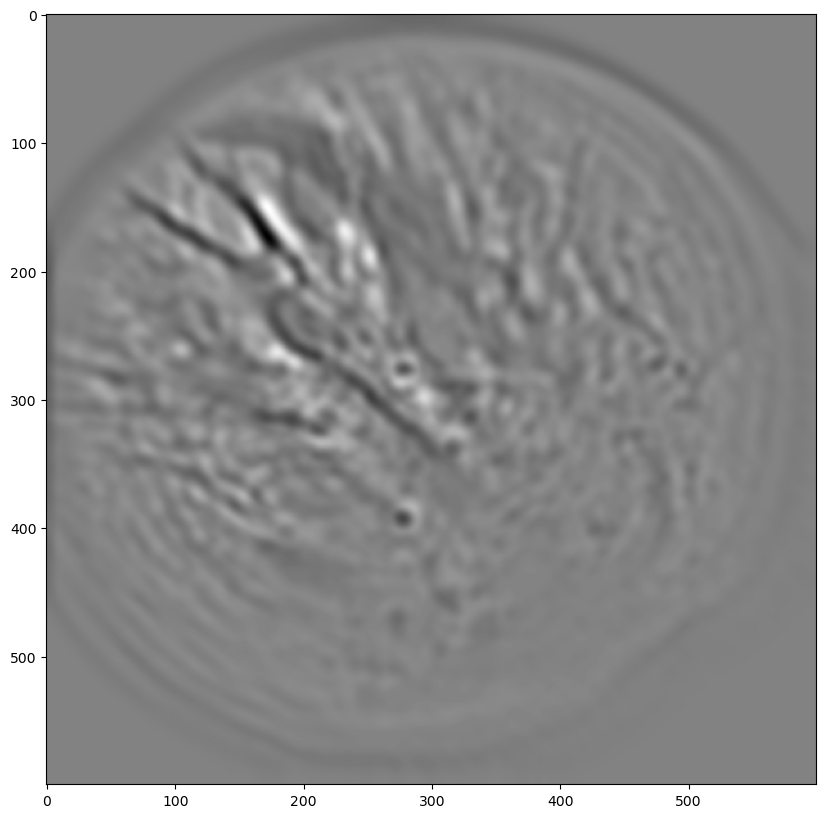

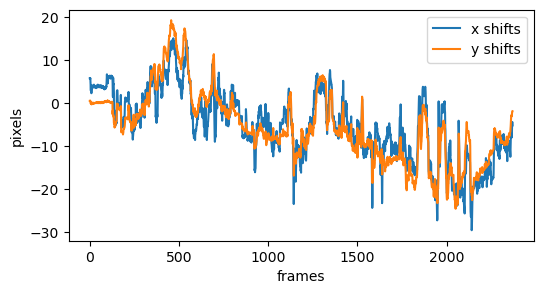

In [58]:
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray')

fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
if pw_rigid:
   bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(int)
else:
    bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(int)
        # Plot shifts
    plt.figure()
    plt.plot(mc.shifts_rig)  # % plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    plt.gcf().set_size_inches(6,3)

In [59]:
downsample_ratio=0.2

In [65]:
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=20, magnification=1.5, bord_px = 0*bord_px_rig) # press q to exit

    70828661 [movies.py:              resize():1065] [30484] reshaping along z


qplot the shifts computed by rigid registration

Text(0, 0.5, 'pixels')

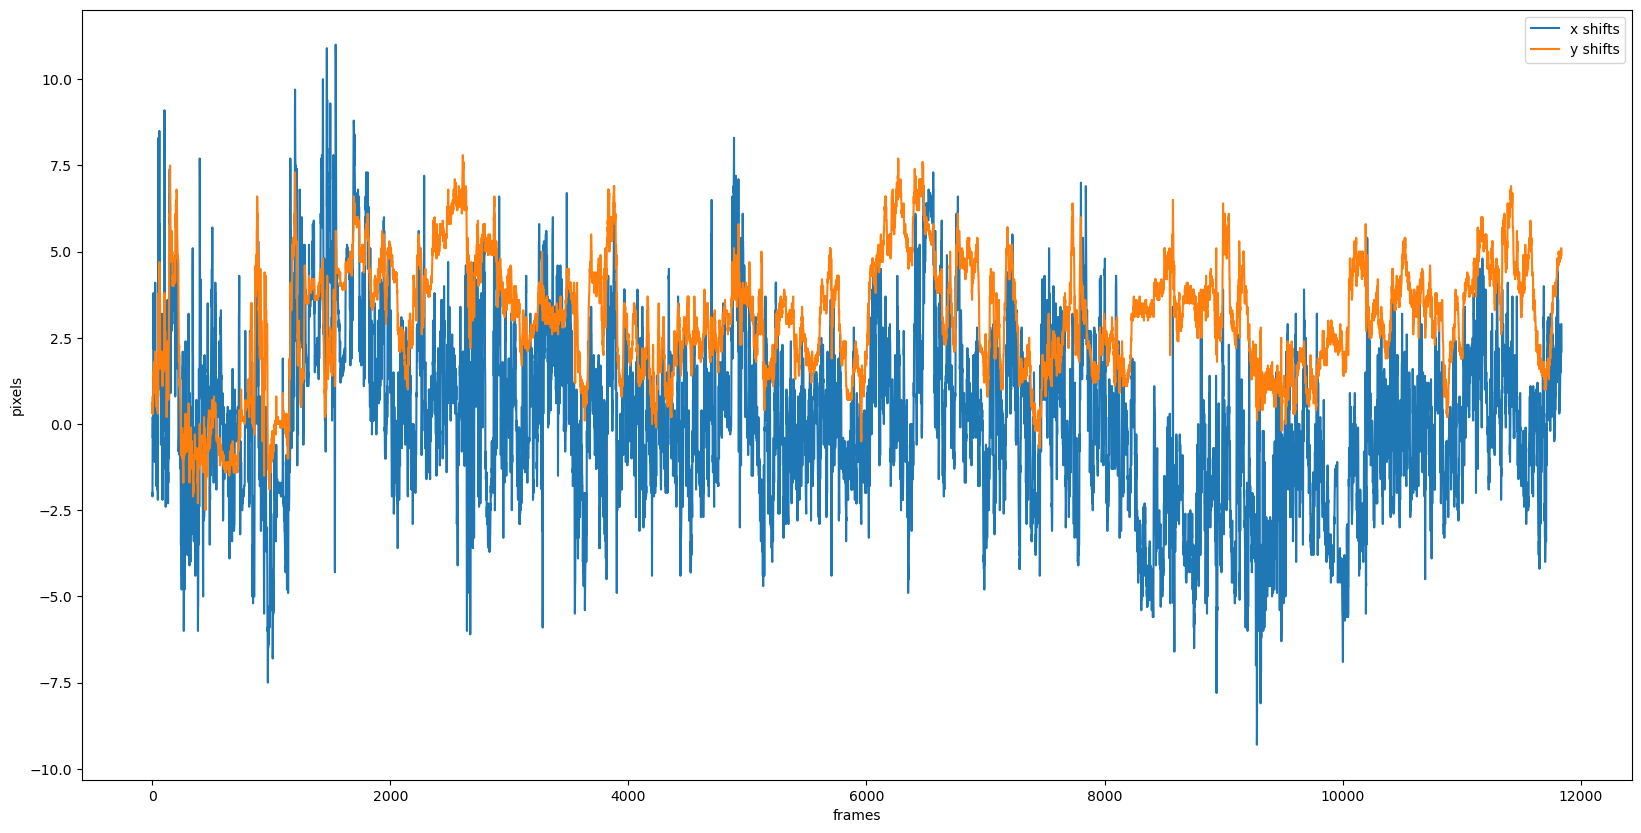

In [9]:
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

## Piecewise rigid registration
While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file. To correct for that we can use piece-wise rigid registration **directly in the original file** by setting `mc.pw_rigid=True`. As before the registered file is saved in a memory mapped format in the location given by `mc.mmap_file`.

In [15]:

attribute = dir(mc)
print(attribute)
print(mc.fname)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'apply_shifts_movie', 'border_nan', 'dview', 'fname', 'gSig_filt', 'indices', 'is3D', 'max_deviation_rigid', 'max_shifts', 'min_mov', 'motion_correct', 'motion_correct_pwrigid', 'motion_correct_rigid', 'niter_rig', 'nonneg_movie', 'num_splits_to_process_els', 'num_splits_to_process_rig', 'overlaps', 'pw_rigid', 'shifts_opencv', 'splits_els', 'splits_rig', 'strides', 'upsample_factor_grid', 'use_cuda', 'var_name_hdf5']
['Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\0.tif', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff

In [85]:
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
#m_els.resize(1, 1, downsample_ratio).play(
#    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

   160148304 [motion_correction.py:motion_correct_batch_pwrigid():3003] [30484] Adding to movie 1.1448247
   160148304 [motion_correction.py:motion_correct_batch_pwrigid():3006] [30484] 0
   160148305 [motion_correction.py:motion_correct_batch_pwrigid():3016] [30484] saving mmap of Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0.tif
   160148377 [motion_correction.py:motion_correction_piecewise():3159] [30484] Number of Splits: 1
   160163560 [motion_correction.py:motion_correction_piecewise():3197] [30484] Saving file as Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_els__d1_600_d2_600_d3_1_order_F_frames_1000.mmap
   160163565 [motion_correction.py:motion_correction_piecewise():3203] [30484] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  

Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_els__d1_600_d2_600_d3_1_order_F_frames_1000.mmap


   160775690 [movies.py:                load():1712] [30484] mmap
 33%|███▎      | 1/3 [00:13<00:27, 13.73s/it]   160775838 [movies.py:                load():1709] [30484] loading mmap file in memory


Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\1_els__d1_600_d2_600_d3_1_order_F_frames_1000.mmap


   160789471 [movies.py:                load():1712] [30484] mmap
 67%|██████▋   | 2/3 [00:27<00:13, 13.77s/it]   160789644 [movies.py:                load():1709] [30484] loading mmap file in memory


Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\2_els__d1_600_d2_600_d3_1_order_F_frames_370.mmap


   160794676 [movies.py:                load():1712] [30484] mmap
100%|██████████| 3/3 [00:32<00:00, 10.88s/it]


In [28]:
print(np.min(m_els.T))
print(np.max(m_els.T))

-1.3190018
56.08797


In [35]:
#del m_orig,m_rig
fname_tot_els = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if ('_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap' in f)]
fname_tot_els = sorted(fname_tot_els, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))
print(fname_tot_els)

['Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\0_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\10_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\11_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\1_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\2_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', 'Z:\\HongliWang\\Miniscope\\data\\Fully_Ball\\customEntValHere\\2024_12_16\\14_06_13\\miniscopeDeviceName\\tiff\\4_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap', '

In [81]:
# try to save a df/f video
#import caiman.base.movies.movie as movie
#m=movie(m_els, start_time=0,fr=20)
del m_els
m_els = cm.load(fname_tot_els[0:2])
new_movie, baselineMov = m_els.computeDFF(secsWindow=4, quantilMin=8,  method = 'only_baseline',in_place = False) 

  0%|          | 0/2 [00:00<?, ?it/s]    89191382 [movies.py:                load():1709] [30484] loading mmap file in memory


Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_16\14_06_13\miniscopeDeviceName\tiff\0_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap


  0%|          | 0/2 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#dir(m_els)
m_els.resize(1, 1, 0.2).play(fr=20, q_max=99.5, magnification=1)

In [88]:

# save as tiff
from skimage import io
fnametiff = os.path.join(input_folder, 'els_concatenated.tif')
io.imsave(fnametiff, np.uint8(m_els), plugin='tifffile') # saves each plane different tiff

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [67]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=60, q_max=99.5, magnification=2, bord_px=bord_px_rig)

NameError: name 'm_orig' is not defined

From the movie we can see that pw-rigid registration corrected for the non uniform motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent. In this case, the shifts along the two axes are stored in `mc.x_shifts_els` and `mc.y_shifts_els`, respectively.

Text(0.5, 0, 'frames')

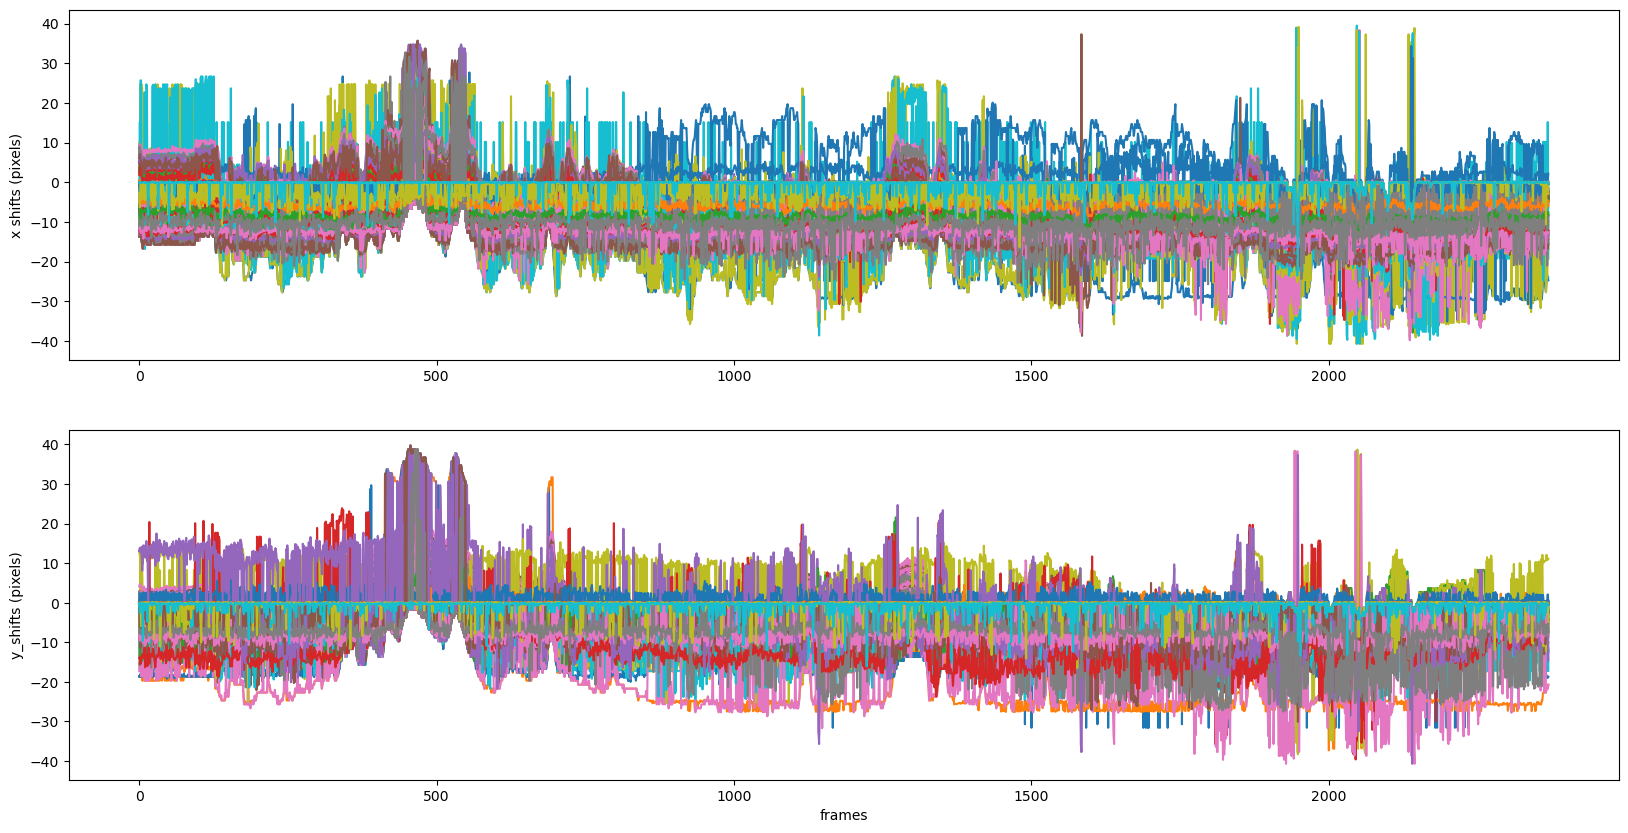

In [68]:
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')

In [89]:
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

C:\Users\linda\miniconda3\envs\caiman\lib\site-packages\caiman\summary_images.py:217: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


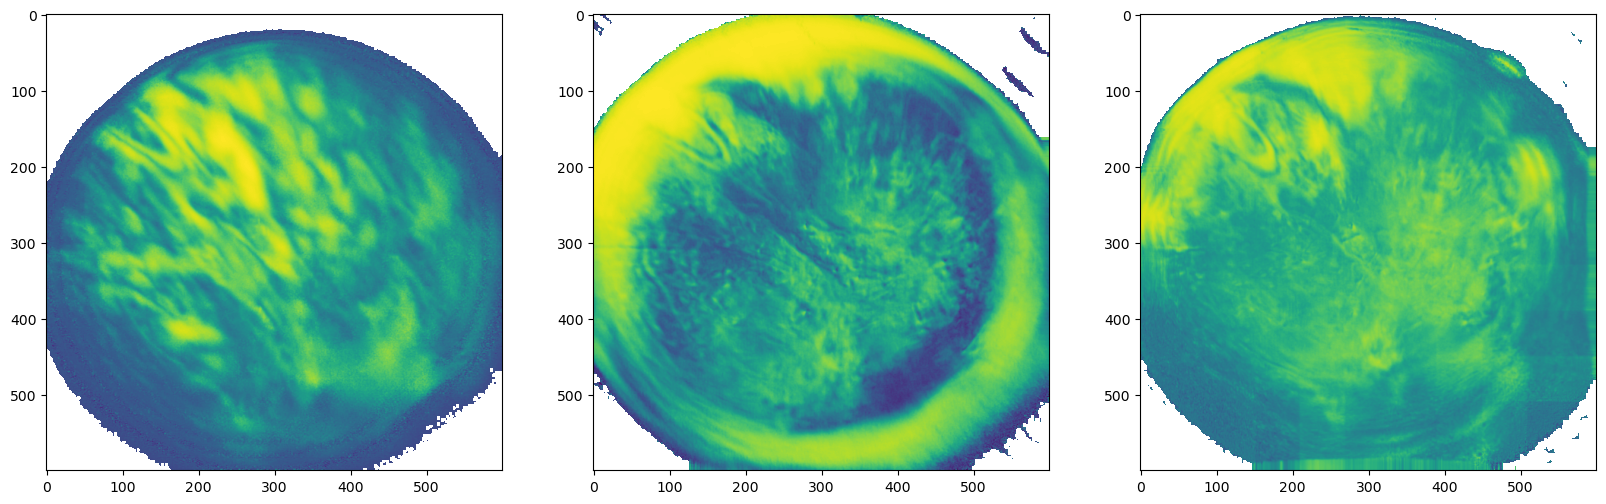

In [93]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [20]:
cm.stop_server(dview=dview) # stop the server

     1159668 [cluster.py:         stop_server():348] [4672] stop_cluster(): done


## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [94]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

   162141130 [motion_correction.py:compute_metrics_motion_correction():2673] [30484] [41, -41, 41, -41]
   162141489 [motion_correction.py:compute_metrics_motion_correction():2680] [30484] Local correlations..
   162144695 [motion_correction.py:compute_metrics_motion_correction():2682] [30484] (1000, 518, 518)
   162147619 [motion_correction.py:compute_metrics_motion_correction():2688] [30484] Compute Smoothness.. 
   162148011 [motion_correction.py:compute_metrics_motion_correction():2694] [30484] Compute correlations.. 
   162148013 [motion_correction.py:compute_metrics_motion_correction():2701] [30484] 0
   162148912 [motion_correction.py:compute_metrics_motion_correction():2701] [30484] 100
   162149579 [motion_correction.py:compute_metrics_motion_correction():2701] [30484] 200
   162150250 [motion_correction.py:compute_metrics_motion_correction():2701] [30484] 300
   162150922 [motion_correction.py:compute_metrics_motion_correction():2701] [30484] 400
   162151582 [motion_correcti

Plot correlation with mean frame for each dataset

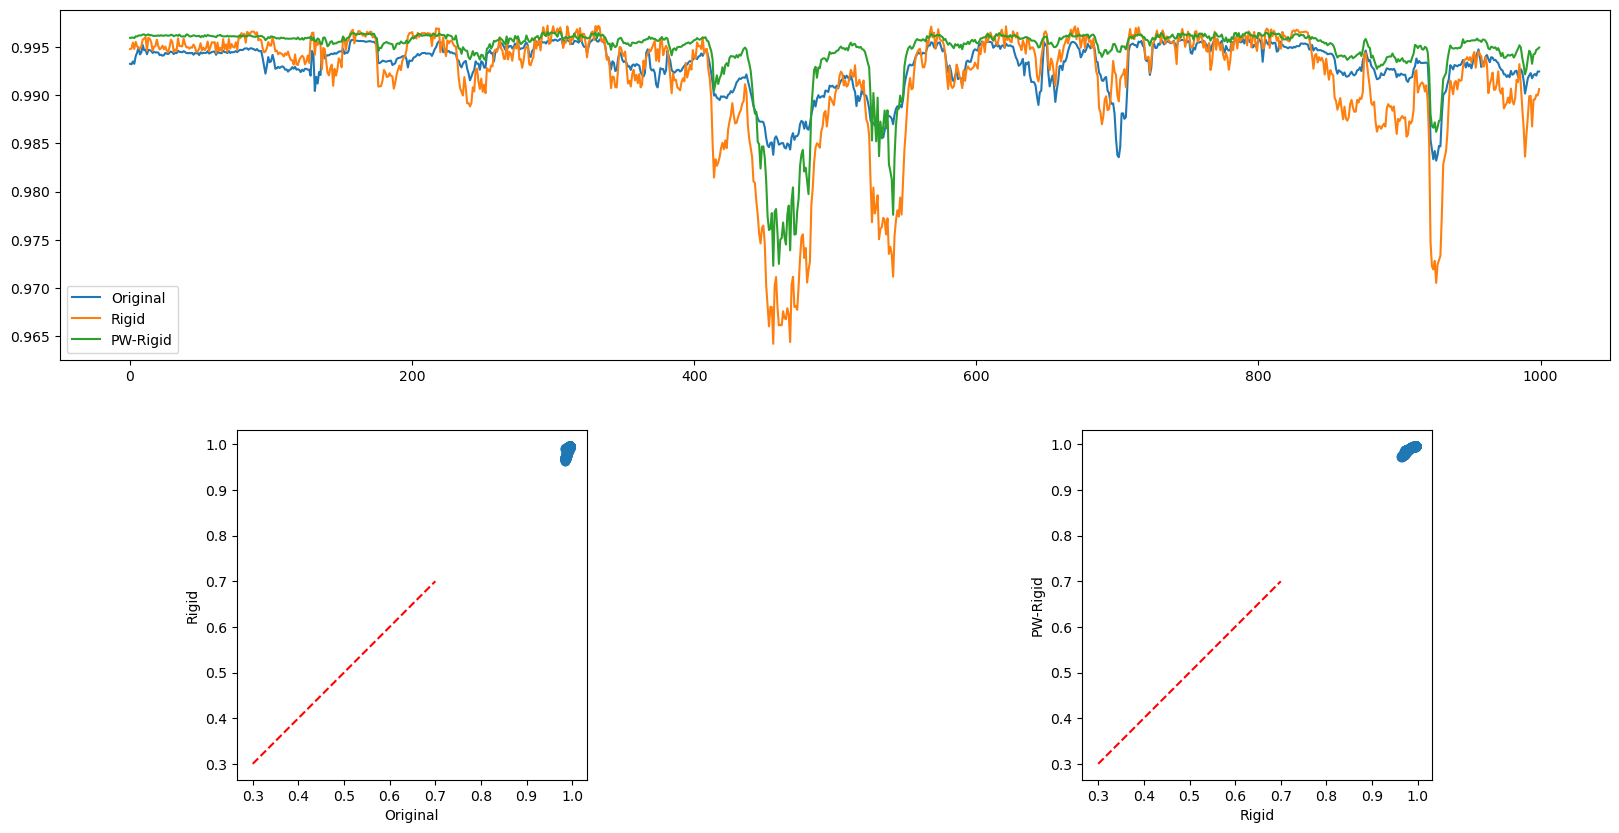

In [95]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [96]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 457
Crispness rigid: 250
Crispness elastic: 250


   162470837 [movies.py:                load():1712] [30484] mmap


KeysView(<numpy.lib.npyio.NpzFile object at 0x0000021E34F09D80>)
Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_els__d1_600_d2_600_d3_1_order_F_frames_1000_metrics.npz
13.924687+/-3.4379773 ; 250.91127 ; nan
Loading data with base Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_els__d1_600_d2_600_d3_1_order_F_frames_1000
Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_els__d1_600_d2_600_d3_1_order_F_frames_1000.mmap


   162488762 [colorbar.py:_get_ticker_locator_formatter():876] [30484] locator: <matplotlib.ticker.AutoLocator object at 0x0000021E34E16D40>
   162488846 [movies.py:                load():1712] [30484] mmap


KeysView(<numpy.lib.npyio.NpzFile object at 0x0000021E34F09D50>)
Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_rig__d1_600_d2_600_d3_1_order_F_frames_1000_metrics.npz
10.773464+/-4.4378037 ; 250.50084 ; nan
Loading data with base Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_rig__d1_600_d2_600_d3_1_order_F_frames_1000
Decode mmap filename Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_rig__d1_600_d2_600_d3_1_order_F_frames_1000.mmap


   162506553 [colorbar.py:_get_ticker_locator_formatter():876] [30484] locator: <matplotlib.ticker.AutoLocator object at 0x0000021E1A35F0D0>
   162506590 [movies.py:                load():1728] [30484] File request:[Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0.mmap] not found!


KeysView(<numpy.lib.npyio.NpzFile object at 0x0000021E34EC3610>)
Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0_metrics.npz
23.882072+/-8.755872 ; 457.44708 ; nan
Loading data with base Z:\HongliWang\Miniscope\data\Fully_Ball\customEntValHere\2024_12_17\15_55_48\miniscopeDeviceName\tiff\0


   162511786 [colorbar.py:_get_ticker_locator_formatter():876] [30484] locator: <matplotlib.ticker.AutoLocator object at 0x0000021E1A6EFA30>
   162511811 [font_manager.py:    _findfont_cached():1378] [30484] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
   162511813 [font_manager.py:    _findfont_cached():1390] [30484] findfont: score(FontEntry(fname='C:\\Users\\linda\\miniconda3\\envs\\caiman\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
   162511814 [font_manager.py:    _findfont_cached():1390] [30484] findfont: score(FontEntry(fname='C:\\Users\\linda\\miniconda3\\envs\\caiman\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
   162511815 [font_

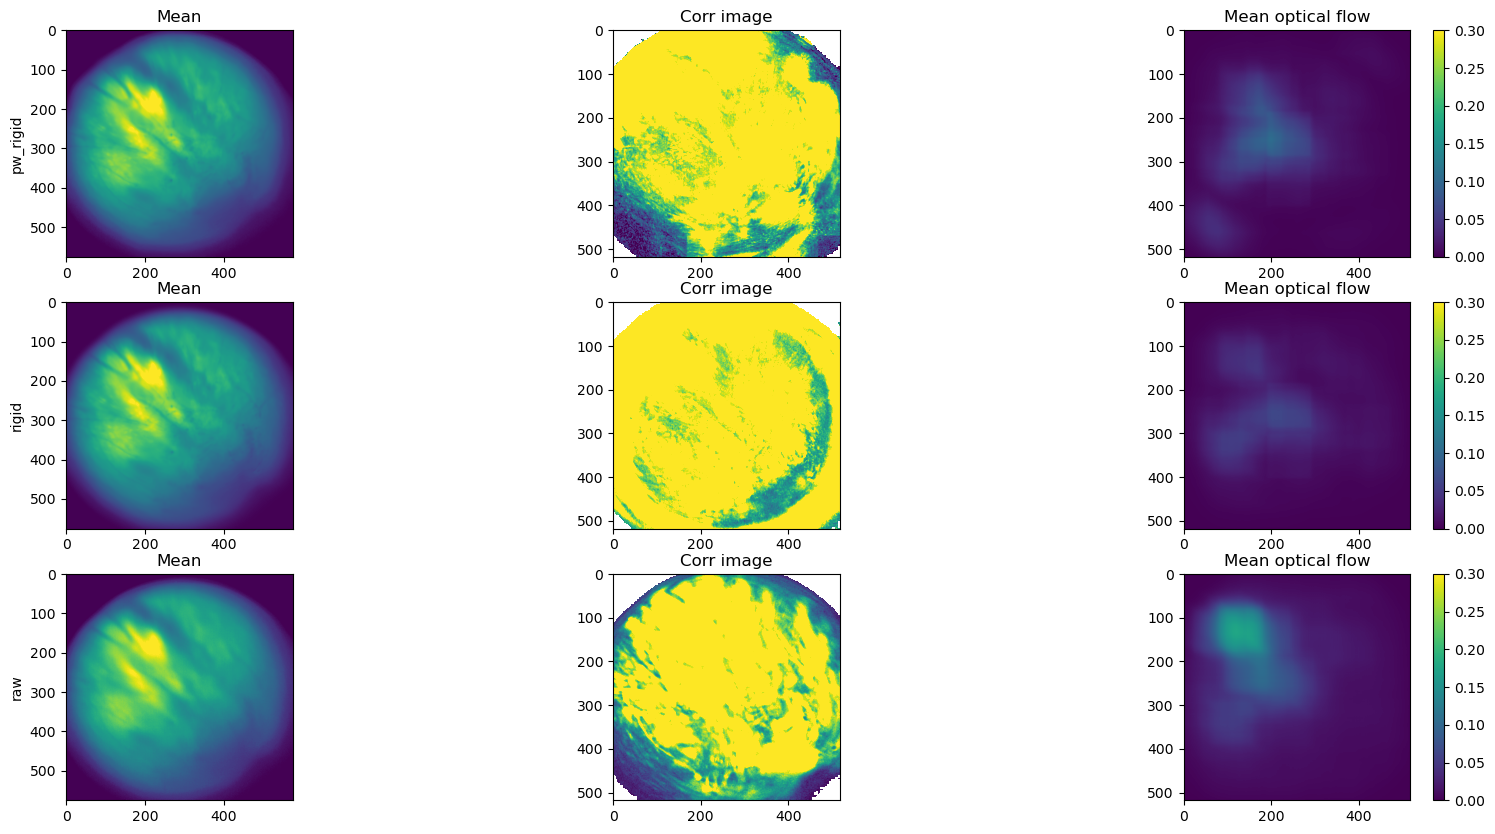

In [97]:
fls = [cm.paths.fname_derived_presuffix(mc.fname_tot_els[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname_tot_rig[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname[0],         'metrics', swapsuffix='npz'),
      ]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        print(f"Loading data with base {fl[:-12]}")
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')      